In [1]:
import numpy as np
import time
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 28}

plt.rc('font', **font)

In [2]:
def create_starting_optic(thick,R,k=-1,N=100):
    z=np.geomspace(1e-6,thick,N) #solves the problem of not having enough points close to the origin
    r=np.sqrt(2*R*z-(k+1)*z**2) 
    optic=np.array([z,r])
    return optic

In [3]:
def find_local_eq(r,optic,N=100):
    # first find nearest point in the lens array to where the ray r intersects
    z=optic[0]
    opt=optic[1]
    index=np.abs(opt-r).argmin()
    
    # isolate a few points around the closest index (look into how many points we actually want)
    lower=index-3 if index-3>0 else 0
    upper=index+3
        
    local_z=np.array(z[lower:upper])
    local_opt=np.array(opt[lower:upper])-r
    
    local_z=local_z[::-1]
    local_opt=-1*local_opt[::-1]
    # Use cubic spline to interpolate the local points
    # need to switch the z and the r coordinates so that cubic spline won't give error
    cs=None
    try:
        cs=CubicSpline(local_opt,local_z)
    except:
        print(local_opt)
        print(lower)
        print(upper)
    #zs=np.linspace(local_z[0],local_z[-1],N) 
    return cs

In [4]:
def find_reflect_slope(norm):
    theta=np.arctan(norm)
    slope=np.tan(2*theta)
    return slope

In [5]:
def raytrace(optic, exp_f, Nr=7, linsp=True):
    #create the starting rays
    opt=optic[1]
    # make sure that the rays are bounded 
    r_min=opt[4]
    r_max=opt[-5]
    
    rays=np.linspace(r_min,r_max,Nr) if linsp else np.geomspace(r_min,r_max,Nr) #confine the rays to the diameter of the optic
    rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic
    after=[]
    for r in rays:
        cs=find_local_eq(r,optic)
        z_optic=cs(0)        
        norm=cs(0,1) #The normal is just the derivative 
        slope=find_reflect_slope(norm)
        r_after=slope*(exp_f-z_optic)+r # This is where the ray meets z=exp_f
        z_bef=exp_f*1.5 # change this so that z_bef all starts at the same z value
        z_ray=[z_bef,z_optic,exp_f]
        r_ray=[r,r,r_after]            
        raymatrix.append([z_ray,r_ray])
        after.append(r_after)
        #np.concatenate(raymatrix)
    return np.array(raymatrix),np.array(after)

In [6]:
def plot(optic,raymatrix,exp_f,title, lambda0=None, norm=False,savefig=False):
    #first plot the optic:
    plt.figure(figsize=(15,10))
    opt_z=optic[0] if not norm else optic[0]/lambda0
    opt_r=optic[1] if not norm else optic[1]/lambda0
    plt.plot(opt_z,opt_r,'b',opt_z,-1*opt_r,'b')
    exp_freq=exp_f if not norm else exp_f/lambda0
    plt.axvline(x=exp_freq, color='k', linestyle='--')
    #Then plot the rays:
    for ray in raymatrix:
        ray_z=ray[0] if not norm else ray[0]/lambda0
        ray_r=ray[1] if not norm else ray[1]/lambda0
        plt.plot(ray_z,ray_r,'r',ray_z,-1*ray_r,'r')
        
    xl='z (m)' if not norm else 'z/lambda'
    yl='r (m)' if not norm else 'r/lambda'
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.xlim((-0.01,exp_f+0.02))
    r_max=max(opt_r)+0.02
    plt.ylim((-r_max,r_max))
    if savefig:
        plt.savefig(title+".png")
    #plt.show()
    plt.close()

In [7]:
def rms(rays_after):
    n=len(rays_after)
    return np.sqrt(np.sum(rays_after**2)/n)

In [8]:
def grad(i,epsilon,optic,signs,exp_f,Nr):
    zeros=np.array([[0,0]])
    optic=np.concatenate((zeros.T,optic),axis=1)
    o_z=optic[0]
    o=optic[1]
    j=i+1
    o_z[j]=o_z[j]+signs[i]*epsilon
    rm1,af1=raytrace([o_z,o],exp_f,Nr)
    o_z[j]=o_z[j]-2*signs[i]*epsilon
    rm2,af2=raytrace([o_z,o],exp_f,Nr)
    c1=rms(af1)
    c2=rms(af2)
    return (c1-c2)

In [9]:
def gradient_descent(epsilon,dz,start_k,thick,roc,exp_f,learn_rate,n_iter=1000,tol=1e-16,No=100,Nr=1000,plt=False,title=None):
    start_o=create_starting_optic(thick,roc,k=start_k,N=No)
    o_r=start_o[1]
    os=[start_o[0]]
    rm0,af0=raytrace(start_o,exp_f,Nr)
    cost=[rms(af0)]
    n=0
    if plt:
        plot(start_o,rm0,exp_f,title+"_%d"%(n),savefig=True)
    diff=1e6
    dzs=np.ones(No)*dz
    cdz=np.array(dzs)
    #print(dzs)
    print('Step: %d\t Cost: %f'%(n,cost[0]))
    o=start_o[0]
    while(n<n_iter and abs(diff)>tol):
        #print(change_dzs)
        start_time=time.time()
        n+=1
        signs=np.random.choice([-1,1],No)
        o=o+signs*dzs #move each point in the optic randomly by dz except for the point at origin
        os.append(o)
        rm,af=raytrace([o,o_r],exp_f,Nr)
        c=rms(af)
        cost.append(c)
        if plt:
            plot([o,o_r],rm,exp_f,title+"_%d"%(n),savefig=True)
        for i in range(len(dzs)):
            step_size=learn_rate*signs[i]*grad(i,epsilon,[o,o_r],signs,exp_f,Nr)
            dzs[i]=dzs[i]-step_size
        diff=np.sum(dzs*dzs)
        cdz=np.vstack([cdz,dzs])
        #print(dzs)
        print('Step: %d\t Cost: %f \t diff: %E \t time: %s'%(n,c,diff,time.time()-start_time))
    return os,o_r,cost,cdz

In [11]:
o,o_r,c,cdz=gradient_descent(1e-7,5e-7,-0.8,0.0064,0.1125,0.05625,1e-6,n_iter=1000,Nr=20,plt=True,title='../k08_rms_mac/step')

Step: 0	 Cost: 0.000114
Step: 1	 Cost: 0.000908 	 diff: 2.500000E-11 	 time: 0.8001737594604492
Step: 2	 Cost: 0.000691 	 diff: 2.500000E-11 	 time: 0.8078820705413818
Step: 3	 Cost: 0.000969 	 diff: 2.500000E-11 	 time: 0.8014216423034668
Step: 4	 Cost: 0.001885 	 diff: 2.500000E-11 	 time: 0.8371598720550537
Step: 5	 Cost: 0.002204 	 diff: 2.500000E-11 	 time: 0.922368049621582
Step: 6	 Cost: 0.002686 	 diff: 2.500000E-11 	 time: 0.8178188800811768
Step: 7	 Cost: 0.002085 	 diff: 2.500000E-11 	 time: 0.8099679946899414
Step: 8	 Cost: 0.003082 	 diff: 2.500000E-11 	 time: 0.8057048320770264
Step: 9	 Cost: 0.003255 	 diff: 2.500000E-11 	 time: 0.8017311096191406
Step: 10	 Cost: 0.003978 	 diff: 2.500000E-11 	 time: 0.8049969673156738
Step: 11	 Cost: 0.003423 	 diff: 2.500000E-11 	 time: 0.8809022903442383
Step: 12	 Cost: 0.002507 	 diff: 2.500000E-11 	 time: 0.8216681480407715
Step: 13	 Cost: 0.001973 	 diff: 2.500000E-11 	 time: 0.8043901920318604
Step: 14	 Cost: 0.002114 	 diff: 2.50

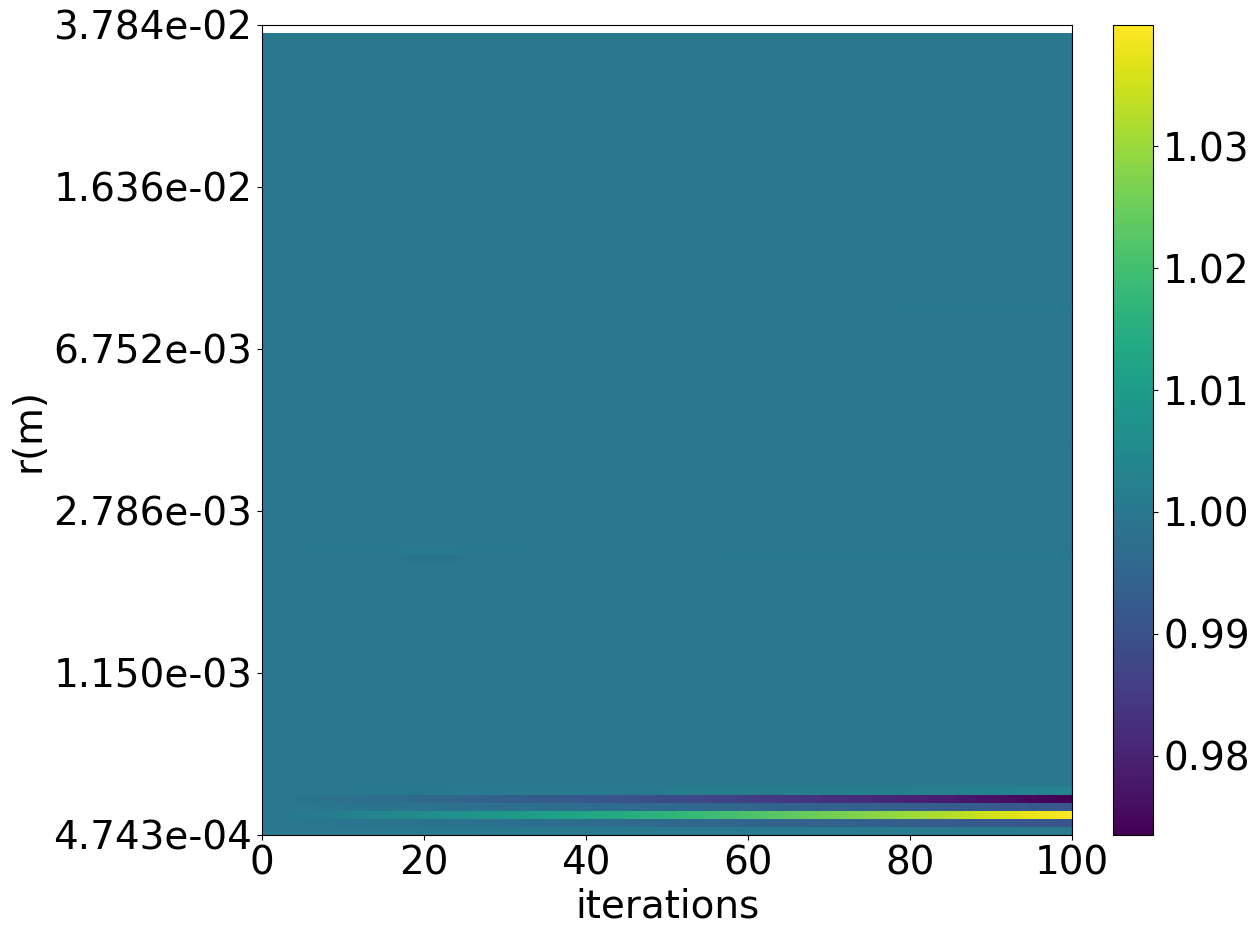

In [12]:
fig, ax = plt.subplots(figsize=(13,10))
im=ax.imshow(np.array(cdz[:90]/cdz[0]).T,origin='lower',extent=[0,100,0,99])
ax.figure.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel('iterations')
plt.ylabel('r(m)')
x_positions=np.linspace(0,100,6)
x_labels=np.append(o_r[::20],o_r[-1])
ax.set_yticks(x_positions)
ax.set_yticklabels(['{:,.3e}'.format(x) for x in x_labels])
plt.tight_layout()
plt.savefig('../cdz_rms_m')
plt.show()

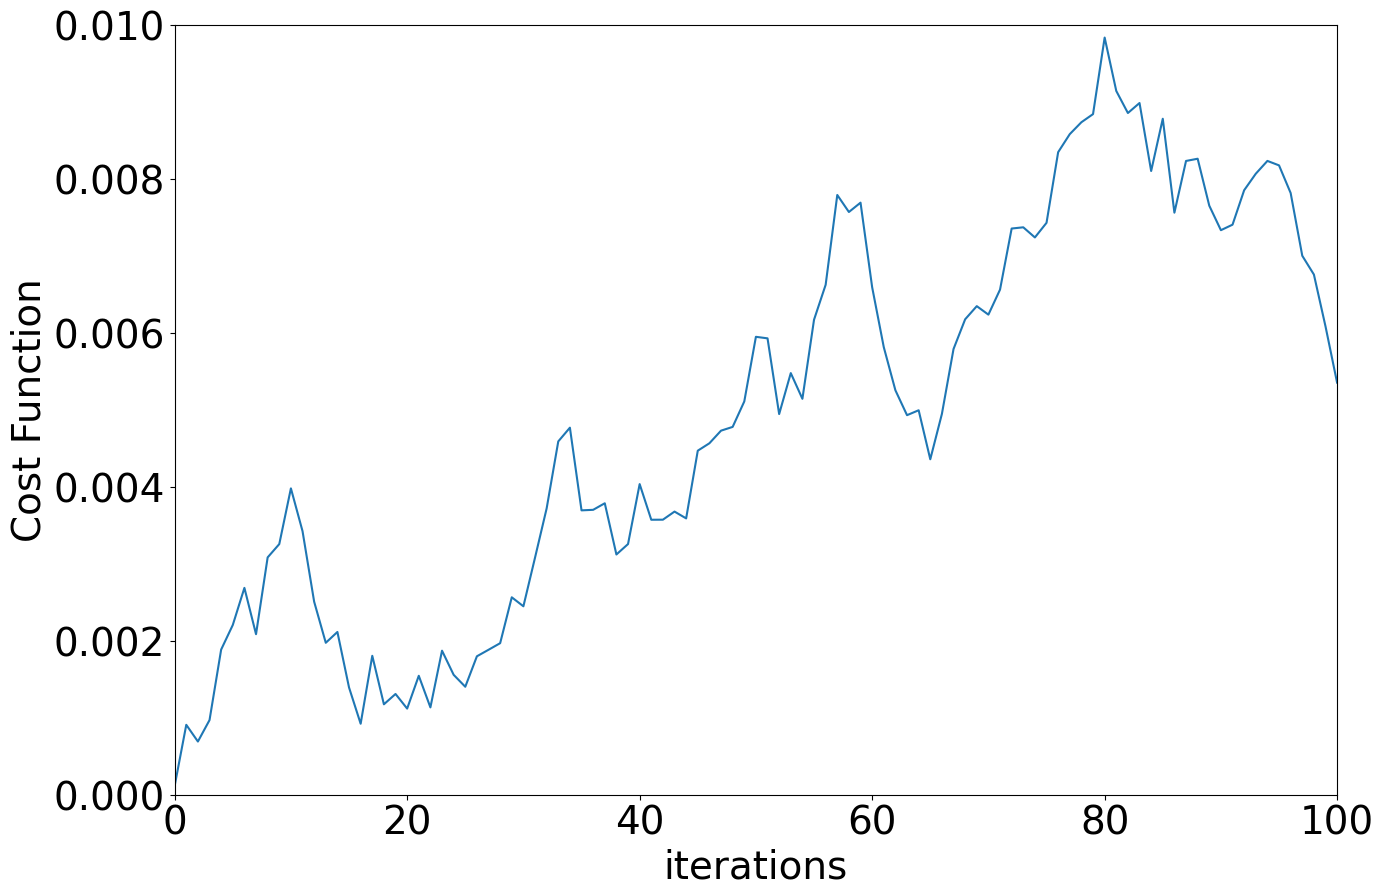

In [14]:
plt.figure(figsize=(15,10))
plt.ylabel('Cost Function')
plt.xlabel('iterations')
plt.xlim((0,100))
plt.ylim((0,0.01))
plt.plot(c)
plt.savefig('../cost_rms_m')